# Table of contents
- Downloading data
- Loading magnitude
- Loading phasor
- Loading waveform
- Loading topology and parameter

Note: In our helper code such as functions `read_ts`, `read_ts_dict`, `align_phasors`, the output data format is our custom "data frame" format. Our custom data frame (df) is dictionary, whose keys are column names such as "timestamps" (Time), "v" (value), etc. and their corresponding values are numpy ndarrays.

In [4]:
# Make sure you are running this notebook in /path/to/digital-twin-dataset/code_examples
import os, sys
assert os.getcwd().endswith('digital-twin-dataset/code_examples'), os.getcwd()
sys.path.append(os.path.join(os.getcwd(), '../utils'))
sys.path.append(os.path.join(os.getcwd(), '..'))
import utils
import matplotlib.pyplot as plt


## Downloading data from API

In [5]:
from dataset_api_client import DatasetApiClient

data_api_client = DatasetApiClient()
data_api_client.download_data(
    magnitudes_for=["egauge_1-L1", "egauge_1-L2", "egauge_1-L3", "egauge_1-CT1", "egauge_1-CT2", "egauge_1-CT3"],
    phasors_for=["egauge_1-L1", "egauge_1-L2", "egauge_1-L3", "egauge_1-S1", "egauge_1-S2", "egauge_1-S3"],
    time_range=('2024-11-14T07:00:00', '2024-11-14T07:05:00'),
    output_dir='../sample_dataset'
)
data_api_client.download_data(
    waveforms_for=['egauge_16-L1', 'egauge_16-L2', 'egauge_16-L3', 'egauge_16-S1', 'egauge_16-S2', 'egauge_16-S3'],
    time_range=('2024-12-03T00:01:00', '2024-12-03T00:01:30'),
    output_dir='../sample_dataset'
)

Downloading: 89.0kB [00:00, 51.4MB/s, 13 files]


Directory already exists. Files may be overwritten.


Downloading: 1.51MB [00:00, 7.97MB/s, 19 files]

Directory already exists. Files may be overwritten.


## Magnitude
Read root mean squred (RMS) magnitudes of voltage and current measurements.

In [6]:
# Read one file
data, err_code = utils.read_ts(
    '../sample_dataset/magnitudes/egauge_1-L1.csv',
    datetimespan=('2024-11-14T07:00:00', '2024-11-14T07:01:00'),
)
fig, ax = plt.subplots(figsize=(6,2))
ax.plot(data['t'], data['v'])
ax.set_xlabel('Time')
ax.set_ylabel('Voltage (V)')
fig.show()

File loading failed for: /home/netlab/tmp/egauge_1-L1.csv


RuntimeError: 't'...

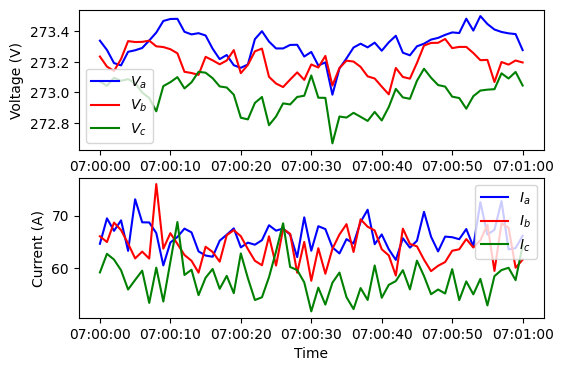

In [ ]:
# Read 3-phase voltage and currents, align irregular timestamps
files_to_read = {
    'V_a': '../sample_dataset/magnitudes/egauge_1-L1.csv',
    'V_b': '../sample_dataset/magnitudes/egauge_1-L2.csv',
    'V_c': '../sample_dataset/magnitudes/egauge_1-L3.csv',
    'I_a': '../sample_dataset/magnitudes/egauge_1-CT1.csv',
    'I_b': '../sample_dataset/magnitudes/egauge_1-CT2.csv',
    'I_c': '../sample_dataset/magnitudes/egauge_1-CT3.csv',
}
timestamps, df_dict = utils.read_ts_dict(
    files_to_read,
    datetimespan=('2024-11-14T07:00:00', '2024-11-14T07:01:00'),
)

fig, axs = plt.subplots(2, 1, figsize=(6,4))
axs[0].plot(timestamps, df_dict['V_a']['v'], label=f'$V_a$', c='b')
axs[0].plot(timestamps, df_dict['V_b']['v'], label=f'$V_b$', c='r')
axs[0].plot(timestamps, df_dict['V_c']['v'], label=f'$V_c$', c='g')
axs[1].plot(timestamps, df_dict['I_a']['v'], label=f'$I_a$', c='b')
axs[1].plot(timestamps, df_dict['I_b']['v'], label=f'$I_b$', c='r')
axs[1].plot(timestamps, df_dict['I_c']['v'], label=f'$I_c$', c='g')
axs[0].set_ylabel('Voltage (V)')
axs[0].legend()
axs[1].set_ylabel('Current (A)')
axs[1].set_xlabel('Time')
axs[1].legend()

## Phasor
Read complex phasor quantities. Here when aligning timestamps, the phase angle offset from timestamp difference is handled by `phasor_utils.py:align_phasors`.

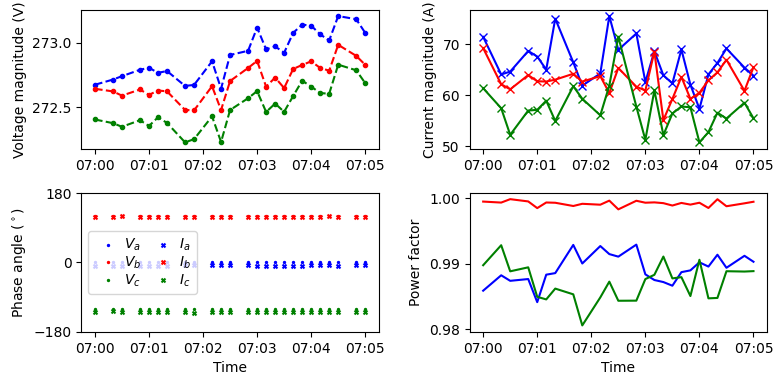

In [ ]:
import phasor_utils
import numpy as np

files_to_read = {
    'V_a': '../sample_dataset/phasors/egauge_1-L1.csv',
    'V_b': '../sample_dataset/phasors/egauge_1-L2.csv',
    'V_c': '../sample_dataset/phasors/egauge_1-L3.csv',
    'I_a': '../sample_dataset/phasors/egauge_1-S1.csv',
    'I_b': '../sample_dataset/phasors/egauge_1-S2.csv',
    'I_c': '../sample_dataset/phasors/egauge_1-S3.csv',
}

timestamps, df_dict = phasor_utils.align_phasors(
    files_to_read, 
    datetimespan=('2024-11-14T07:00:00', '2024-11-14T07:05:00'), 
    # Set phase A voltage as the angle reference (0 degrees)
    ref='V_a',
)
c = ['blue', 'red', 'green']
fig, axs = plt.subplots(2, 2, figsize=(8,4))
for i, phase in enumerate(('a', 'b', 'c')):
    axs[0, 0].plot(timestamps, df_dict[f'V_{phase}']['rms'], marker='.', linestyle='--', c=c[i])
    axs[1, 0].scatter(timestamps, df_dict[f'V_{phase}']['phase'], marker='.', label=f'$V_{phase}$', c=c[i], s=8)
for i, phase in enumerate(('a', 'b', 'c')):
    axs[0, 1].plot(timestamps, df_dict[f'I_{phase}']['rms'], marker='x', c=c[i])
    axs[1, 0].scatter(timestamps, df_dict[f'I_{phase}']['phase'], marker='x', label=f'$I_{phase}$', c=c[i], s=8)
    pwr_factor = np.cos((df_dict[f'I_{phase}']['phase'] - df_dict[f'V_{phase}']['phase']) / 180 * np.pi)
    axs[1, 1].plot(timestamps, pwr_factor, c=c[i])

import matplotlib.dates as mdates
timefmt = mdates.DateFormatter('%I:%M')
axs[0, 0].set_ylabel('Voltage magnitude (V)')
axs[0, 1].set_ylabel('Current magnitude (A)')
axs[1, 0].set_yticks((-180, 0, 180))
axs[1, 0].set_ylim((-180, 180))
axs[1, 0].set_ylabel('Phase angle ($^\circ$)')
axs[1, 0].set_xlabel('Time')
axs[1, 1].set_ylabel('Power factor')
axs[1, 1].set_xlabel('Time')
axs[1, 0].legend(ncol=2, labelspacing=0.1, columnspacing=0.5, handletextpad=0.2)
for i in range(2):
    for j in range(2):
        axs[i, j].xaxis.set_major_formatter(timefmt)
fig.tight_layout()

## Waveform
Here we show basic manipulation of waveform data
- Load multiple waveforms captured at the same time
- Alignment of waveform timestamps (resample into regular intervals)
- Load multiple waveforms captured over a time range

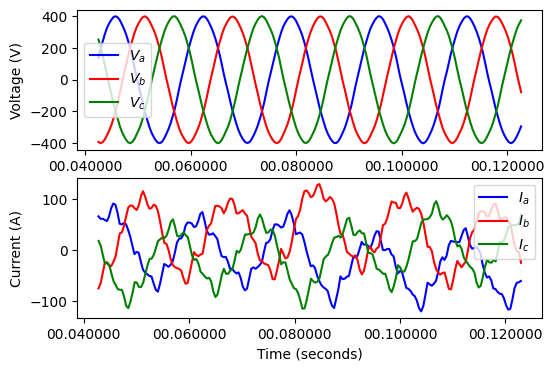

In [ ]:
# Here, the loaded waveforms are not timestamp-aligned
egauge_list = ['egauge_16-L1', 'egauge_16-L2', 'egauge_16-L3', 'egauge_16-S1', 'egauge_16-S2', 'egauge_16-S3']
waveform_dict = utils.load_waveforms('../sample_dataset/waveforms', '2024-12-03T00:01:00', egauge_list)
data = list(waveform_dict.values())[0]

import matplotlib.dates as mdates
timefmt = mdates.DateFormatter('%S.%f')
c = ['blue', 'red', 'green']
N = 200
fig, axs = plt.subplots(2, 1, figsize=(6,4))
for i, phase in enumerate(('a', 'b', 'c')):
    axs[0].plot(data[f'egauge_16-L{i+1}']['t'][:N], data[f'egauge_16-L{i+1}']['v'][:N], label=f'$V_{phase}$', c=c[i])
axs[0].set_ylabel('Voltage (V)')
axs[0].legend()
for i, phase in enumerate(('a', 'b', 'c')):
    axs[1].plot(data[f'egauge_16-S{i+1}']['t'][:N], data[f'egauge_16-S{i+1}']['v'][:N], label=f'$I_{phase}$', c=c[i])
axs[1].set_ylabel('Current (A)')
axs[1].legend()
axs[1].set_xlabel('Time (seconds)')
axs[0].xaxis.set_major_formatter(timefmt)
axs[1].xaxis.set_major_formatter(timefmt)

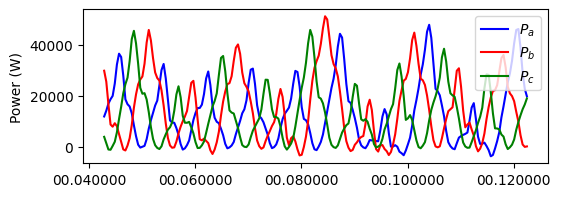

In [ ]:
# Align the waveform timestamps by re-sampling to regular intervals
# Calculation of instantaneous power requires aligned voltage/current waveforms
waveform_dict = utils.resample_waveforms(waveform_dict)
data = list(waveform_dict.values())[0]

N = 200
fig, ax = plt.subplots(figsize=(6,2))
for i, phase in enumerate(('a', 'b', 'c')):
    ax.plot(
        data[f'egauge_16-S{i+1}']['t'][:N],
        data[f'egauge_16-S{i+1}']['v'][:N]*data[f'egauge_16-L{i+1}']['v'][:N],
        label=f'$P_{phase}$', c=c[i]
    )
ax.set_ylabel('Power (W)')
axs[1].set_xlabel('Time (seconds)')
ax.legend()
ax.xaxis.set_major_formatter(timefmt)

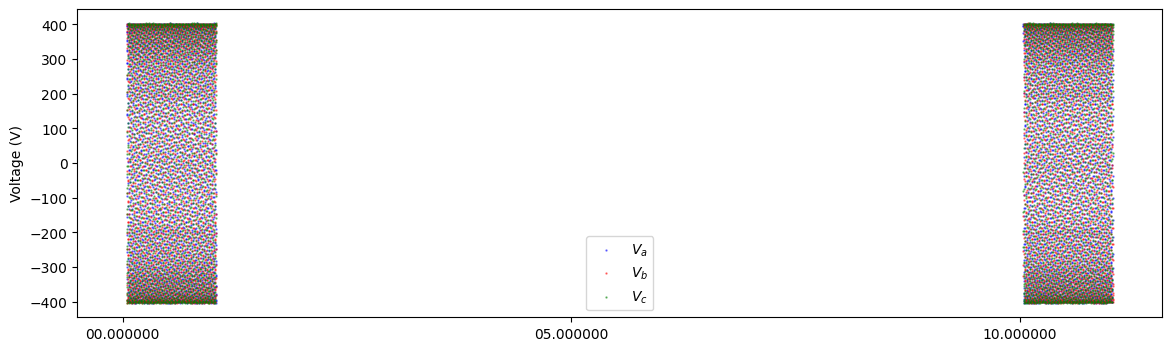

In [ ]:
import pandas as pd
# Load multiple waveforms over a time range
egauge_list = ['egauge_16-L1', 'egauge_16-L2', 'egauge_16-L3']
waveform_dict = utils.load_waveforms_timerange(
    '../sample_dataset/waveforms', 
    ('2024-12-03T00:01:00', '2024-12-03T00:01:20'), 
    egauge_list
)
data_t1 = list(waveform_dict.values())[0]
data_t2 = list(waveform_dict.values())[1]
data_join = {k: pd.concat([data_t1[k], data_t2[k]]) for k in data_t1.keys()}

# We join the two dataframes to plot them together
# Waveforms are 1-second-long, captured every 10 seconds (10% coverage)
# The time axis is very long, so the sinusoidal waveforms are squished
fig, ax = plt.subplots(figsize=(14,4))
for i, phase in enumerate(('a', 'b', 'c')):
    ax.scatter(data_join[f'egauge_16-L{i+1}']['t'], data_join[f'egauge_16-L{i+1}']['v'], label=f'$V_{phase}$', c=c[i], s=0.5, alpha=0.5)
ax.set_ylabel('Voltage (V)')
axs[1].set_xlabel('Time (seconds)')
ax.legend()
ax.xaxis.set_major_formatter(timefmt)

## Topology and parameter
The circuit topology and parameter data are stored in `.json` files under `sample_dataset/topology/network_files`. Use helper functions under `utils/topology.py` to load and manipulate these data.  

The network files describe the **physical asset network**. Power transfer elements (e.g. lines, transformers, switches) are the graph **edges**, buses are the **nodes**, and power injections (e.g. inverters, EV chargers) and electrical meters are **decorators**.

The **electrical network** can be derived by zero- and infinite-impedance elements (e.g. short lines, closed/open breakers). Then nodes connected by zero-impedance elements are combined into a single node.

Finally, since the circuit topology changes over time (e.g. due to line outages, switching, new load connection), certain parameters are time-varying. Their values are stored in `sample_dataset/topology/parameter_timeseries`. Therefore when loading the circuit topology, a timestamp must be specified. The timestamps for which the circuit changes are stored under `sample_dataset/topology/metadata`.

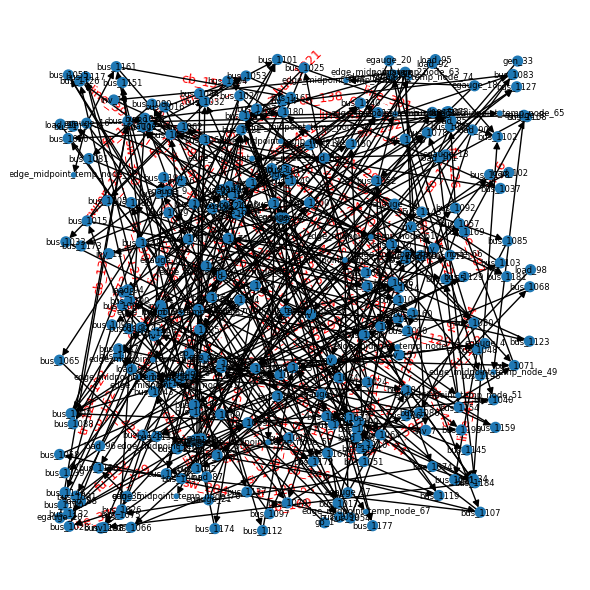

In [ ]:
import copy
import networkx as nx
from global_param import FILE_PATHS
import topology

# Load physical asset network
net_files = ['../sample_dataset/topology/network_files/circuit3']
element_parents = utils.dict_parents(utils.load_json(FILE_PATHS["element_inheritance"]))
net_data = topology.load_net_files(net_files, t=utils.now(mode="np"))
nodes, edges, decorators = topology.net2graph(net_data, element_parents)

# Plot the physical asset network: very crowded plot, many elements
topology.plot_graph(nodes, edges, decorators, layout=nx.random_layout, figsize=(6, 6))

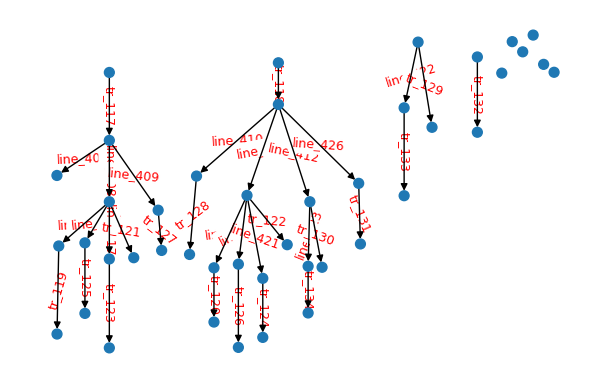

In [ ]:
# Generate the electrical network from physical asset network
# Remove zero- and infinite-impedance edges. Combine nodes connected by zero-impedance edges.
nodes_elec, edges_elec, decorators_elec = topology.graph2electrical_graph(
    copy.deepcopy(nodes),
    copy.deepcopy(edges),
    {},
    net_data,
    element_parents,
)
# Plot the electrical network (without bus names, otherwise too crowded)
topology.plot_graph(
    nodes_elec, edges_elec, decorators_elec, 
    layout='tree', figsize=(6, 4), with_labels=False
)

This is the same topology as paper Figure 2.
<p align="center">
  <img src="../assets/figure2.png" width="600"/>
</p>

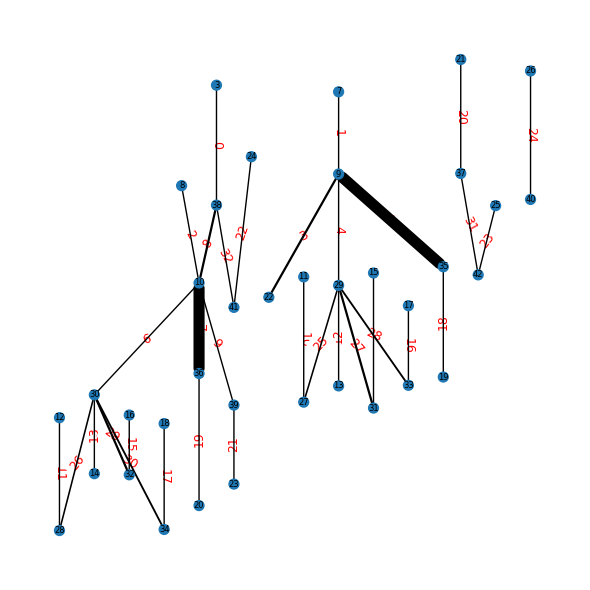

In [ ]:
# Generate the network admittance matrix
node_list = list(nodes_elec.keys())
Y = topology.network_Y_matrix(edges_elec, node_list, net_data)
# Here the nodes have been shuffled around
topology.plot_Y_matrix(Y, W=3, figsize=(6, 6), plot_mtx=False)